In [11]:
import csv
import itertools
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import torch

from regions_of_interest_module.regions_of_interest import find_points_of_interest
from image_manipulation.crop_image_for_classifier import crop, is_valid_size
from image_loader.Image2numpy import convert_image_file_to_numpy
from image_manipulation.standardize_image import normalize_image

# now comes the neural network
from noise_reduction.model_denoise import DenoiseNet
from neural_network.model_classifier import spots_classifier_net as ClassifierNet

from image_loader.load_tagged_image import load_tagged_image
from create_training_data.training_data_generator import TaggedImagesGenerator

NUM_OF_ROI_IN_BATCH = 300

In [12]:
image_cleaner_network = DenoiseNet()
image_cleaner_network.load_state_dict(torch.load('denoiseNet.pt', map_location=torch.device('cpu')))

classifier_network = ClassifierNet()
classifier_network.load_state_dict(torch.load("classifyNet.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
def clean_image(image: npt.NDArray) -> npt.NDArray:
    image = torch.tensor(image)  # type: ignore
    image = image.permute(3, 2, 1, 0)  # get ch,z,x,y # type: ignore
    image_real = image.unsqueeze(1)  # type: ignore
    pred = image_cleaner_network(image_real.float()).detach()
    pred = pred[:, 0, :, :, :]
    pred = pred.permute(3, 2, 1, 0)
    return pred.numpy()

def classify_roi_list(small_images_list: npt.NDArray, cutoff=0.95):
    images = torch.tensor(small_images_list)  # type: ignore
    images = images.permute(0, 4, 3, 2, 1)  # get ch,z,x,y # type: ignore
    pred = classifier_network(images.float()).detach()
    pred = torch.sigmoid(pred)
    has_point = pred.numpy() > cutoff
    result_channel = np.zeros(has_point.shape)
    return has_point, result_channel

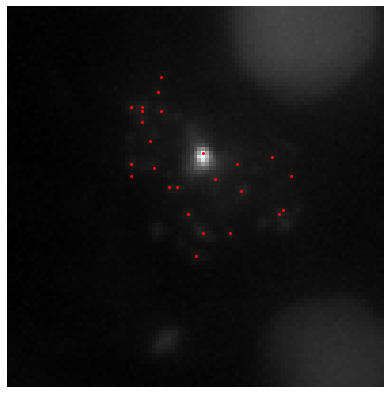

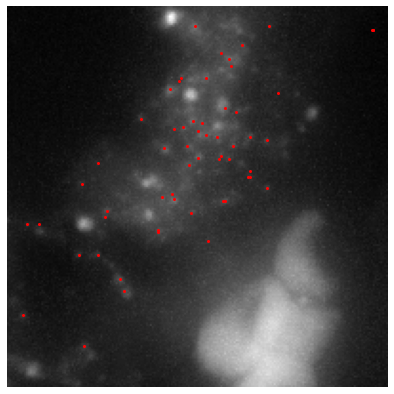

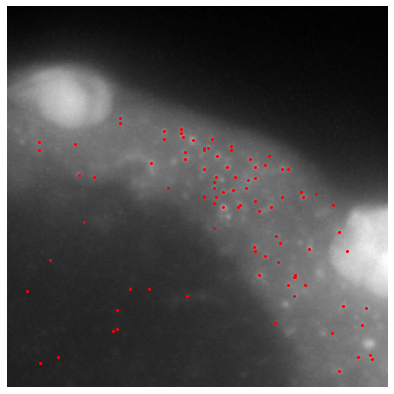

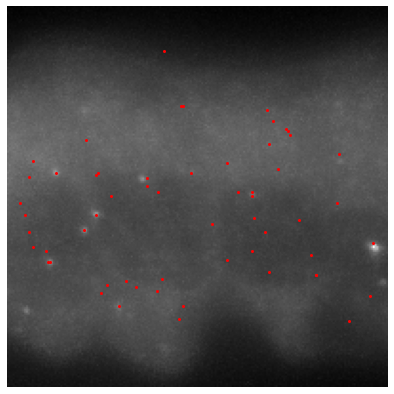

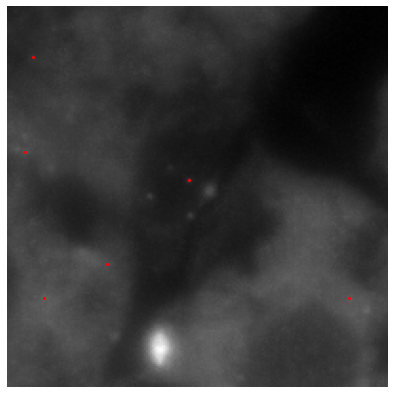

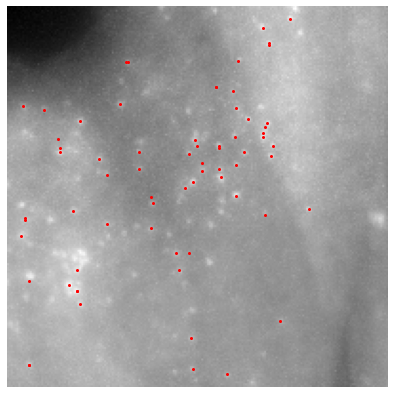

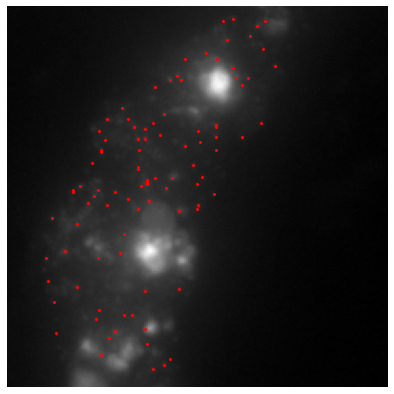

In [17]:
import os

cutoff = 0.95

for i in range(1,8):    
    ogimage, tags = load_tagged_image(f"images\\tagged_images_validation\\img{i}")
    
    # if i == 6:
    #     ogimage = ogimage[:100,:100,...]

    image = normalize_image(ogimage)
    image = image[..., :3]
    image = clean_image(image)

    points_of_interest = list(zip(*np.where(find_points_of_interest(image))))  # type: ignore
    points_of_interest: list[tuple[int, int, int]]  # points_of_interest = list of (x,y,z) points

    # prepare a batch of small images
    small_images_arr = []
    small_images_center_location_arr = []
    for point in points_of_interest:
        small_image = crop(ogimage, point[0], point[1])
        if not is_valid_size(small_image):
            continue
        small_images_arr.append(small_image)
        small_images_center_location_arr.append(point)
    small_images_arr = np.array(small_images_arr)
    small_images_center_location_arr = np.array(small_images_center_location_arr)
    small_images_arr_copy = np.copy(small_images_arr)
    has_point_list, result_channels_list = classify_roi_list(small_images_arr_copy, cutoff)
    
    import matplotlib.font_manager as font_manager
    
    ch = int(tags[-1][3])
    plt.figure(figsize=(10,7))
    plt.imshow(np.max(ogimage[...,ch],axis=-1),cmap="gray")
    # plt.plot(tags[:,0],tags[:,1],".g",markersize=5, label="Manual Validation Tags")
    plt.plot(small_images_center_location_arr[has_point_list,1],small_images_center_location_arr[has_point_list,0],".r",markersize=4, label="Predicted")
    plt.axis("off")
    font = font_manager.FontProperties(style='normal', size=16)
    # plt.legend(prop=font)
    plt.gcf().savefig(os.path.join("result_images",f"im{i}.tiff"))